# Exercise with bank marketing data

## Introduction

- Data from the UCI Machine Learning Repository: [data](https://github.com/justmarkham/DAT8/blob/master/data/bank-additional.csv), [data dictionary](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Goal:** Predict whether a customer will purchase a bank product marketed over the phone
- `bank-additional.csv` is already in our repo, so there is no need to download the data from the UCI website

## Step 1: Read the data into Pandas

In [67]:
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bank-additional.csv'
bank = pd.read_csv(url, sep=';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## Step 2: Prepare at least three features

- Include both numeric and categorical features
- Choose features that you think might be related to the response (based on intuition or exploration)
- Think about how to handle missing values (encoded as "unknown")

In [41]:
# list all columns (for reference)
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### y (response)

In [42]:
# convert the response to numeric values and store as a new column
bank['outcome'] = bank.y.map({'no':0, 'yes':1})

### age

In [43]:
%matplotlib inline

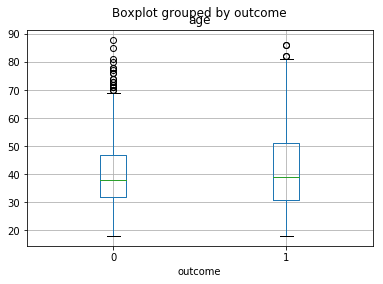

In [44]:
# probably not a great feature
bank.boxplot(column='age', by='outcome')

### job

In [45]:
# looks like a useful feature
bank.groupby('job').outcome.mean()

job
admin.           0.131423
blue-collar      0.069005
entrepreneur     0.054054
housemaid        0.100000
management       0.092593
retired          0.228916
self-employed    0.081761
services         0.089059
student          0.231707
technician       0.115774
unemployed       0.171171
unknown          0.102564
Name: outcome, dtype: float64

In [46]:
# create job_dummies (we will add it to the bank DataFrame later)
job_dummies = pd.get_dummies(bank.job, prefix='job')
job_dummies.drop(job_dummies.columns[0], axis=1, inplace=True)

### default

In [47]:
# looks like a useful feature
bank.groupby('default').outcome.mean()

default
no         0.121267
unknown    0.061021
yes        0.000000
Name: outcome, dtype: float64

In [48]:
# but only one person in the dataset has a status of yes
bank.default.value_counts()

no         3315
unknown     803
yes           1
Name: default, dtype: int64

In [49]:
# so, let's treat this as a 2-class feature rather than a 3-class feature
bank['default'] = bank.default.map({'no':0, 'unknown':1, 'yes':1})

### contact

In [50]:
# looks like a useful feature
bank.groupby('contact').outcome.mean()

contact
cellular     0.141403
telephone    0.051806
Name: outcome, dtype: float64

In [51]:
# convert the feature to numeric values
bank['contact'] = bank.contact.map({'cellular':0, 'telephone':1})

### month

In [52]:
# looks like a useful feature at first glance
bank.groupby('month').outcome.mean()

month
apr    0.167442
aug    0.100629
dec    0.545455
jul    0.082982
jun    0.128302
mar    0.583333
may    0.065312
nov    0.096413
oct    0.362319
sep    0.406250
Name: outcome, dtype: float64

In [53]:
# but, it looks like their success rate is actually just correlated with number of calls
# thus, the month feature is unlikely to generalize
bank.groupby('month').outcome.agg(['count', 'mean']).sort_values('count')

,count,mean
month,,
dec,22,0.545455
mar,48,0.583333
sep,64,0.406250
oct,69,0.362319
apr,215,0.167442
nov,446,0.096413
jun,530,0.128302
aug,636,0.100629
jul,711,0.082982


### duration

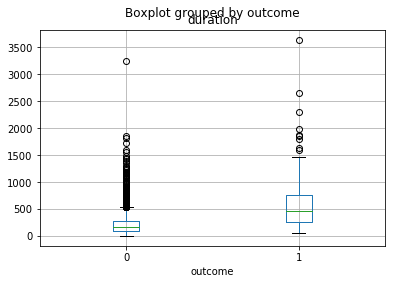

In [54]:
# looks like an excellent feature, but you can't know the duration of a call beforehand, thus it can't be used in your model
bank.boxplot(column='duration', by='outcome')

### previous

In [55]:
# looks like a useful feature
bank.groupby('previous').outcome.mean()

previous
0    0.082884
1    0.208421
2    0.410256
3    0.600000
4    0.714286
5    1.000000
6    0.500000
Name: outcome, dtype: float64

### poutcome

In [56]:
# looks like a useful feature
bank.groupby('poutcome').outcome.mean()

poutcome
failure        0.147577
nonexistent    0.082884
success        0.647887
Name: outcome, dtype: float64

In [57]:
# create poutcome_dummies
poutcome_dummies = pd.get_dummies(bank.poutcome, prefix='poutcome')
poutcome_dummies.drop(poutcome_dummies.columns[0], axis=1, inplace=True)

In [58]:
# concatenate bank DataFrame with job_dummies and poutcome_dummies
bank = pd.concat([bank, job_dummies, poutcome_dummies], axis=1)

### euribor3m

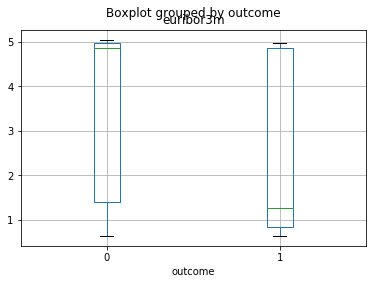

In [59]:
# looks like an excellent feature
bank.boxplot(column='euribor3m', by='outcome')

## Step 3: Model building

- Use cross-validation to evaluate the AUC of a logistic regression model with your chosen features
- Try to increase the AUC by selecting different sets of features

In [60]:
# new list of columns (including dummy columns)
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'outcome',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [61]:
# create X (including 13 dummy columns)
feature_cols = ['default', 'contact', 'previous', 'euribor3m'] + list(bank.columns[-13:])
X = bank[feature_cols]

In [62]:
# create y
y = bank.outcome

In [63]:
# calculate cross-validated AUC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression(C=1e9)
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.75566564072331199

# Random Forest Regressor

In [124]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
rfreg = RandomForestClassifier()
rfreg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [125]:
X.head()

,default,contact,previous,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,poutcome_nonexistent,poutcome_success
0,0,0,0,1.313,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,4.855,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,4.962,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,4.959,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,4.191,0,0,0,0,0,0,0,0,0,0,0,1,0


In [126]:
from sklearn.model_selection import cross_val_score
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [70]:
import matplotlib.pyplot as plt

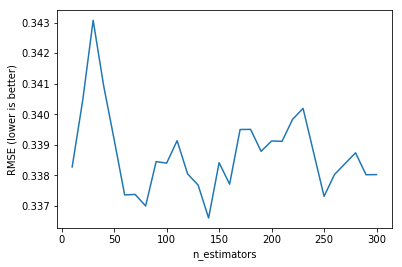

In [127]:
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

In [128]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestClassifier(n_estimators=140, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

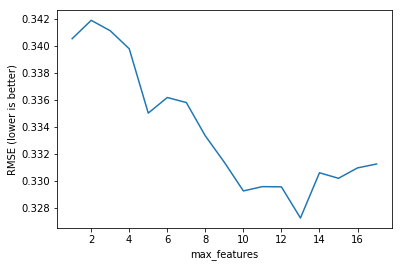

In [129]:
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [130]:
sorted(zip(RMSE_scores, feature_range))[0]

(0.32723232766820365, 13)

In [140]:
rfreg = RandomForestClassifier(n_estimators=140, max_features=13, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=13, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [141]:
freq_imp = pd.DataFrame({'feature':feature_cols, 'importances':rfreg.feature_importances_}).sort_values('importances', ascending=False)

In [142]:
freq_imp

,feature,importances
3,euribor3m,0.579066
16,poutcome_success,0.077847
2,previous,0.044263
12,job_technician,0.036952
1,contact,0.034474
0,default,0.031657
4,job_blue-collar,0.028928
8,job_retired,0.027398
7,job_management,0.025741
11,job_student,0.021214


In [143]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.88807963097839282

In [144]:
print ('Features that have importances more than 0.01')
print (freq_imp[freq_imp['importances']>= .01].shape)
print ('Features that have importances more than the mean of all features')
imp_mean = freq_imp['importances'].mean()
print (freq_imp[freq_imp['importances']>= imp_mean].shape)
print ('Features that have importances more than the median of all features')
imp_median = freq_imp['importances'].median()
print (freq_imp[freq_imp['importances']>= imp_median].shape)

Features that have importances more than 0.01
(14, 2)
Features that have importances more than the mean of all features
(2, 2)
Features that have importances more than the median of all features
(9, 2)


In [145]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rfreg, threshold=0.01, prefit=True)
X_important = sfm.transform(X)
print(X_important.shape[0],X_important.shape[1])

4119 14


In [147]:
rfreg = RandomForestClassifier(n_estimators=140, max_features=13, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='accuracy')
np.mean(scores)

0.89245257636487474

In [148]:
rfreg = RandomForestClassifier(n_estimators=140, max_features=13, random_state=1)
rfreg.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=13, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [149]:
sfm = SelectFromModel(rfreg, threshold='median', prefit=True)
X_important = sfm.transform(X)
print(X_important.shape[0],X_important.shape[1])

4119 9


In [150]:
rfreg = RandomForestRegressor(n_estimators=300, max_features=4, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='neg_mean_squared_error')
np.mean(scores)

-0.089414287698643541

In [152]:
rfreg = RandomForestRegressor(n_estimators=300, max_features=11, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=11, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [153]:
sfm = SelectFromModel(rfreg, threshold='mean', prefit=True)
X_important = sfm.transform(X)
print(X_important.shape[0],X_important.shape[1])

4119 2


In [154]:
rfreg = RandomForestClassifier(n_estimators=300, max_features=2, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='accuracy')
np.mean(scores)

0.89536225066461128